In [14]:
import copy

from alns import ALNS
from alns.select import RouletteWheel
from alns.stop import MaxRuntime
from alns.accept import HillClimbing

import numpy as np
import pandas as pd
from functions.part1 import part1
from classes.deliveryrouting import DeliveryRouting

In [15]:
instance_dir = "data/0o50t75s1p100"
dr = DeliveryRouting(instance_dir)
dr.driver_code()

In [68]:
def random_destroy(State : DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    destroyed = copy.deepcopy(State)
    destroyed.current_solution = copy.deepcopy(destroyed.final_result)

    order_to_destroy = np.random.choice(destroyed.orders, 10)
    destroyed.unassigned = order_to_destroy

    mapping = []

    for order_destroyed in order_to_destroy:
        for time, routes in destroyed.final_result.items():
            for route in routes:
                for bundle in route:
                    if order_destroyed in bundle.bundle:
                        bundle.bundle.remove(order_destroyed)
                        mapping.append(dict(time = time, order = order_destroyed))

    destroyed.removed = mapping
    return destroyed

In [142]:
d.final_result[220][0][0]

In [143]:
def greedy_assign(State: DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    repaired = copy.deepcopy(State)
    destroyed_order = repaired.unassigned

    for i in repaired.removed:
        time, destroyed_order = i.values()
        source_restaurant_id = destroyed_order.restaurant_id

        min_time = 1e9

        routes = repaired.final_result[time]
        for route in routes:
            for bundle in route:
                if len(bundle.bundle) > 0:
                    restaurant_id = bundle.bundle[0].restaurant_id
                    if restaurant_id == source_restaurant_id:
                        for i in range(len(bundle.bundle)):
                            temp_bundle = copy.deepcopy(bundle)
                            temp_bundle.bundle.insert(i, destroyed_order)

                            if temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations) < min_time:
                                min_time = temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations)
                                best_route = route.index(bundle)
                                best_position = i
                                best_routes = routes.index(route)
                else:
                    best_routes = routes.index(route)
                    best_route = route.index(bundle)
                    best_position = 0

        to_check = repaired.final_result[time][best_routes][best_route]
        to_check.bundle.insert(best_position, destroyed_order)

    return repaired

In [144]:
import numpy.random as rnd

alns = ALNS(rnd.RandomState(42))
alns.add_destroy_operator(random_destroy)
alns.add_repair_operator(greedy_assign)

In [153]:
init = dr
select = RouletteWheel([8, 4, 2, 1], 0.8, 1, 1)
accept = HillClimbing()
stop = MaxRuntime(240)

result = alns.iterate(init, select, accept, stop)

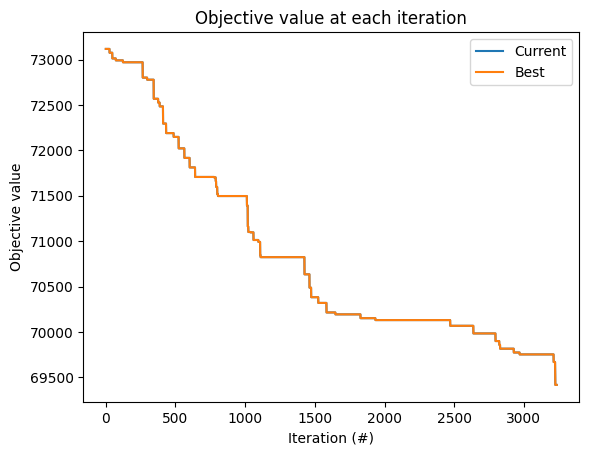

In [154]:
result.plot_objectives()

In [155]:
best_result = result.best_state

In [156]:
import docplex.mp
from docplex.mp.model import Model
model = Model()

In [52]:
couriers = best_result.couriers
work_vars = model.continuous_var_dict(keys=couriers, lb = 0, name = "work")

In [36]:
output = {}
for _ , k in enumerate(best_result.final_result):
    output[_] = (k, best_result.final_result[k])

In [53]:
couriers

In [62]:
def remove_reinsert(dr: DeliveryRouting, t: int, r: str, meters_per_minute: int, locations: pd.DataFrame):
    U = dr.orders_by_horizon_interval[t][r]  # Get the orders U(t, r) for the given time t and restaurant r

    for o in U:
        # Remove o from its current route
        original_route, original_position = dr.find_order_route(o)
        if original_route:
            original_route.bundle.pop(original_position)

        # Find route s and position i(s) to re-insert o at minimum cost
        min_cost = float('inf')
        best_route = None
        best_position = None

        for route in dr.routes_by_horizon_interval[t][r]:
            for i in range(len(route.bundle) + 1):
                # Insert o into route s at position i
                route.bundle.insert(i, o)

                # Calculate the new route cost
                new_cost = route.get_route_cost(meters_per_minute, locations)

                # Check if the new cost is less than the current minimum cost
                if new_cost < min_cost:
                    min_cost = new_cost
                    best_route = route
                    best_position = i

                # Remove o from route s at position i
                route.bundle.pop(i)

        # Re-insert o into route s at position i(s)
        if best_route:
            best_route.bundle.insert(best_position, o)

    # Update the routes
    dr.routes_by_horizon_interval[t][r] = [route for route in dr.routes_by_horizon_interval[t][r] if route.bundle]

    return dr

In [64]:
remove_reinsert(dr, 0, "r1", dr.meters_per_minute, dr.locations)

TypeError: list indices must be integers or slices, not str

In [70]:
dr.orders_by_horizon_interval[50]